In [1]:
import pandas as pd
import numpy as np
import dateutil
import seaborn as sns
import matplotlib.pyplot as plt
 
# Load data from csv file
df2016 = pd.read_csv('2016MarathonResults.csv', encoding='cp1252', usecols = ['Category','First Name','Gender','10k', '30k', 'Gun Time', 'Halfway', 'Last Name', 'Year'])
df2015 = pd.read_csv('2015MarathonResults.csv', encoding='cp1252', usecols = ['Category','First Name','Gender','10k', '30k', 'Gun Time', 'Halfway', 'Last Name', 'Year'])
df2017 = pd.read_csv('2017MarathonResults.csv', encoding='cp1252', usecols = ['Category','First Name','Gender','10k', '30k', 'Gun Time', 'Halfway', 'Last Name', 'Year'])
df = pd.concat([df2016, df2015, df2017], ignore_index=True)
#df.to_csv('out.csv')

# cleanup by removing datasets no longer required in memory
del df2016
del df2015
del df2017

In [2]:
def time_to_mins(x):
    if x is not '-':
        time = x.split(":")
        hours = int(time[0])
        mins = int(time[1])
        secs = int(time[2])
        total_mins = hours*60 + mins + secs/60
        return total_mins

In [67]:
# Remove rows where no valid result
df= df[df['Gun Time'] != 'DNF']
df.dropna(subset=['10k'], inplace=True)
df.dropna(subset=['Halfway'], inplace=True)
df.dropna(subset=['30k'], inplace=True)

#Calculate the time in minutes
df["10k Time (mins)"] = df["10k"].apply(lambda x: time_to_mins(x))
df["Halfway Time (mins)"] = df["Halfway"].apply(lambda x: time_to_mins(x))
df["30k Time (mins)"] = df["30k"].apply(lambda x: time_to_mins(x))
df["Total Time (mins)"] = df["Gun Time"].apply(lambda x: time_to_mins(x))

#Calculate the speed for each stage
df["First 10k speed"] = df["10k Time (mins)"] / 10
df["10k to 21k speed"] = ( df["Halfway Time (mins)"] - df["10k Time (mins)"] ) / 11
df["21k to 30k speed"] = ( df["30k Time (mins)"] - df["Halfway Time (mins)"] ) / 9
df["30k to 42k speed"] = ( df["Total Time (mins)"] - df["30k Time (mins)"] ) / 12
df["First Half speed"] = ( df["Halfway Time (mins)"] ) / 21
df["Second Half speed"] = ( df["Total Time (mins)"] - df["Halfway Time (mins)"] ) / 21
df["Total speed"] = ( df["Total Time (mins)"] ) / 42

#Hitting the wall: using 20% rule
df['Hit the Wall'] = 'Not Hit'
df['Hit the Wall Flag'] = 'No'
df.loc[(df["30k to 42k speed"] > (df["21k to 30k speed"] * 1.2)), 'Hit the Wall'] = 'Between 30k and End'
df.loc[(df["21k to 30k speed"] > (df["10k to 21k speed"] * 1.2)), 'Hit the Wall'] = 'Between 21k and 30k'
df.loc[(df["10k to 21k speed"] > (df["First 10k speed"] * 1.2)), 'Hit the Wall'] = 'Between 10k and 21k'
df.loc[(df["30k to 42k speed"] > (df["21k to 30k speed"] * 1.2)), 'Hit the Wall Flag'] = 'Yes'
df.loc[(df["21k to 30k speed"] > (df["10k to 21k speed"] * 1.2)), 'Hit the Wall Flag'] = 'Yes'
df.loc[(df["10k to 21k speed"] > (df["First 10k speed"] * 1.2)), 'Hit the Wall Flag'] = 'Yes'

# Add new Super Category dividing people into groupings
df['Super Category'] = 'Men Young'
df.loc[df.Category.isin(['FU19','FS']),'Super Category'] = 'Female Young'
df.loc[df.Category.isin(['M35','M40', 'M45', 'M50', 'M55']),'Super Category'] = 'Men Middle'
df.loc[df.Category.isin(['F35','F40', 'F45', 'F50', 'F55']),'Super Category'] = 'Female Middle'
df.loc[df.Category.isin(['M60','M65', 'M70', 'M75', 'M80', 'M85', 'M90', 'M95']),'Super Category'] = 'Men Oldies'
df.loc[df.Category.isin(['F60','F65', 'F70', 'F75', 'F80', 'F85', 'F90', 'F95']),'Super Category'] = 'Female Oldies'

df.head()

,10k,30k,Category,First Name,Gender,Gun Time,Halfway,Last Name,Year,10k Time (mins),...,First Half speed,Second Half speed,Total speed,Super Category,Wall 10k to 21k,Wall 21k to 30k,Wall 30k to 42k,Hit the Wall,Hit the Wall & Gender,Hit the Wall Flag
0,00:31:44,01:33:40,MS,Dereje Debele,Male,02:12:18,01:05:35,Tulu,2016,31.733333,...,3.123016,3.176984,3.150000,Men Young,No,No,No,Not Hit,Not HitMale,No
1,00:31:58,01:34:31,MS,Dereje Urgecha,Male,02:14:38,01:06:18,Beyecha,2016,31.966667,...,3.157143,3.253968,3.205556,Men Young,No,No,No,Not Hit,Not HitMale,No
2,00:31:59,01:34:32,MS,Asefa Legese,Male,02:15:01,01:06:18,Bekele,2016,31.983333,...,3.157143,3.272222,3.214683,Men Young,No,No,No,Not Hit,Not HitMale,No
3,00:32:00,01:34:32,MS,Peter Chege,Male,02:15:54,01:06:19,Wangari,2016,32.000000,...,3.157937,3.313492,3.235714,Men Young,No,No,No,Not Hit,Not HitMale,No
4,00:32:26,01:36:45,MS,Yurii,Male,02:16:16,01:08:07,Ruskyuk,2016,32.433333,...,3.243651,3.245238,3.244444,Men Young,No,No,No,Not Hit,Not HitMale,No


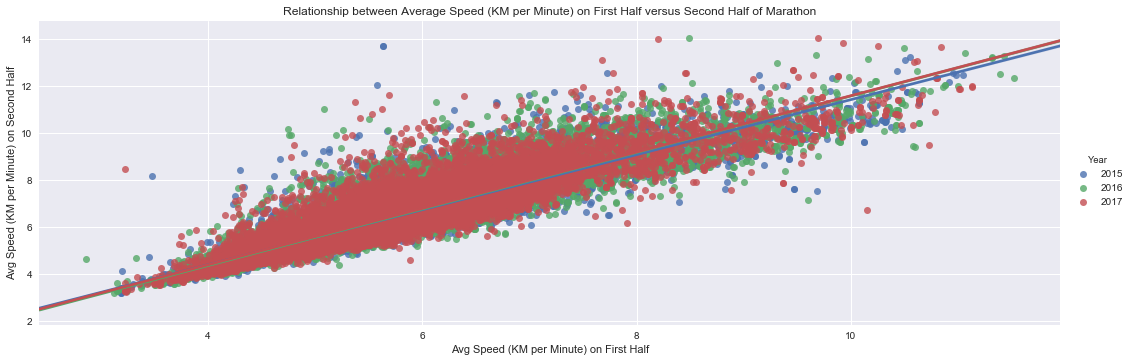

In [4]:
# Relationship between speed for first half versus second half
g = sns.lmplot(x='First Half speed', y='Second Half speed', data=df, hue='Year', size=5, aspect=3)
g = (g.set_axis_labels("Avg Speed (KM per Minute) on First Half", "Avg Speed (KM per Minute) on Second Half"))
plt.title('Relationship between Average Speed (KM per Minute) on First Half versus Second Half of Marathon')
plt.show()

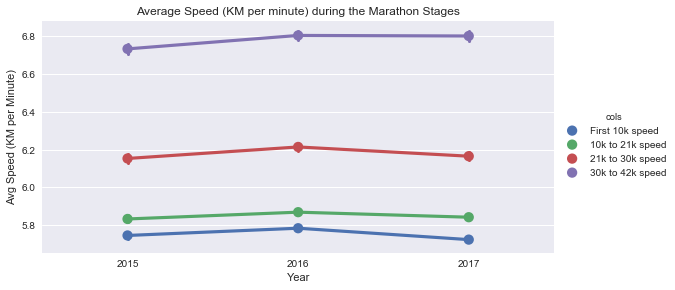

Note: Speed decreases as race progresses consistently across the years!


In [5]:
# Speed during the Marathon Stages
df_melt = pd.melt(df, id_vars=['Year'], value_vars=['First 10k speed', '10k to 21k speed', '21k to 30k speed', '30k to 42k speed'], var_name='cols',  value_name='vals')
g = sns.factorplot(x="Year", y="vals", hue='cols', data=df_melt, size=4, aspect=2)
g = (g.set_axis_labels("Year", "Avg Speed (KM per Minute)"))
plt.title('Average Speed (KM per minute) during the Marathon Stages')
plt.show()
print ("Note: Speed decreases as race progresses consistently across the years!")

Year  Gender
2015  Female    281.608840
      Male      246.730698
2016  Female    283.031549
      Male      248.081463
2017  Female    280.619211
      Male      248.027786
Name: Total Time (mins), dtype: float64

Are we speeding up each year?


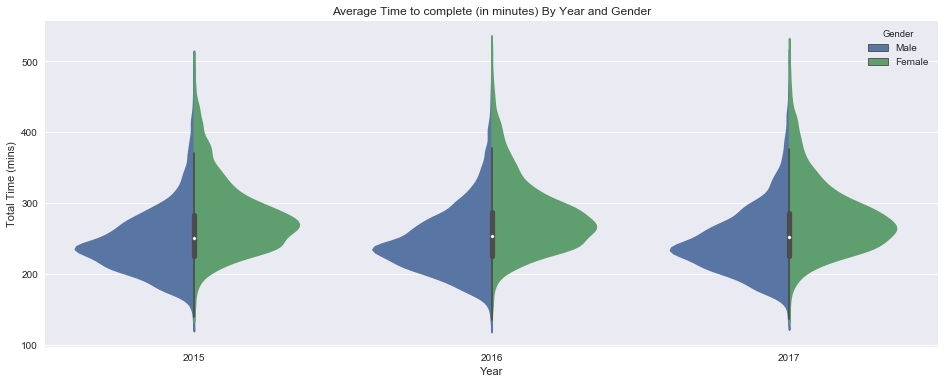

In [6]:
# Are we speeding up?
# Average Time in Minutes broken down by Year and Gender
print (df.groupby(['Year', 'Gender'])['Total Time (mins)'].mean())
print ("")
print ('Are we speeding up each year?')

plt.figure(figsize=(16,6))
g = sns.violinplot(x="Year", y="Total Time (mins)", hue="Gender", data=df, split=True)
plt.title('Average Time to complete (in minutes) By Year and Gender')
plt.show()

Year  Gender
2015  Female    6.704972
      Male      5.874540
2016  Female    6.738846
      Male      5.906702
2017  Female    6.681410
      Male      5.905423
Name: Total speed, dtype: float64

Are we speeding up each year?


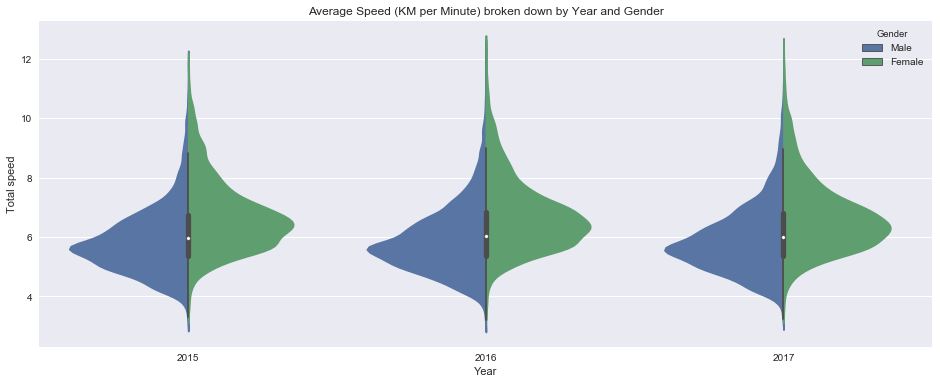

In [7]:
# Are we speeding up?
# Average Speed (KM per Minute) broken down by Year and Gender
print (df.groupby(['Year', 'Gender'])['Total speed'].mean())
print ("")
print ('Are we speeding up each year?')

plt.figure(figsize=(16,6))
g = sns.violinplot(x="Year", y="Total speed", hue="Gender", data=df, split=True)
plt.title('Average Speed (KM per Minute) broken down by Year and Gender')
plt.show()

Year  Super Category
2015  Female Middle     281.161883
      Female Oldies     331.105219
      Female Young      278.596827
      Men Middle        244.666365
      Men Oldies        299.938952
      Men Young         244.167556
2016  Female Middle     283.064837
      Female Oldies     334.028472
      Female Young      278.714424
      Men Middle        246.549969
      Men Oldies        295.137476
      Men Young         246.595879
2017  Female Middle     280.696879
      Female Oldies     335.470952
      Female Young      275.773165
      Men Middle        246.037297
      Men Oldies        295.402729
      Men Young         247.940636
Name: Total Time (mins), dtype: float64


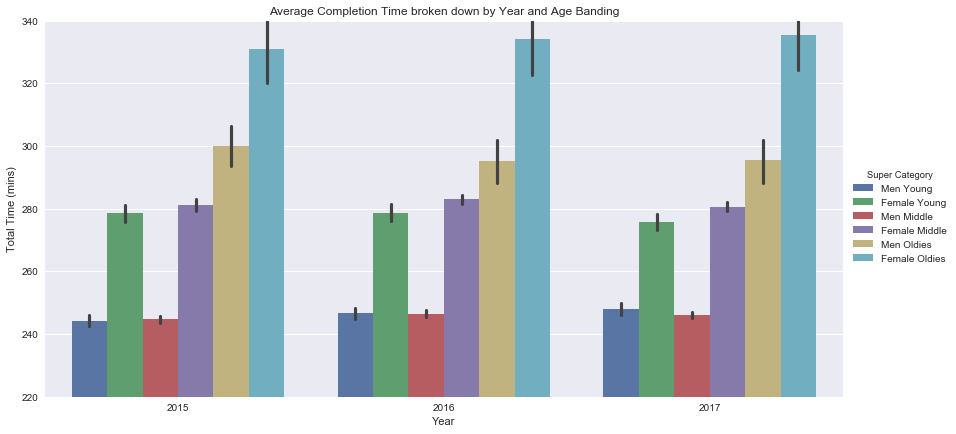

In [15]:
# Lets look at the breakdown by Age Grouping
#print (df.groupby(['Year', 'Super Category'])['Total Time (mins)'].count())
print (df.groupby(['Year', 'Super Category'])['Total Time (mins)'].mean())
#print (df_age_count.groupby(level=[0]).apply(lambda x: x / x.sum()))

# Are oldies getting fitter and the young getting slower?
plt.figure(figsize=(16,6))
horder = ['Men Young', 'Female Young', 'Men Middle', 'Female Middle', 'Men Oldies', 'Female Oldies']
g = sns.factorplot(x="Year", y="Total Time (mins)", hue="Super Category", data=df, kind="bar", hue_order = horder, size=6, aspect=2);
g.set(ylim=(220, 340)) 
plt.title('Average Completion Time broken down by Year and Age Banding')
plt.show()

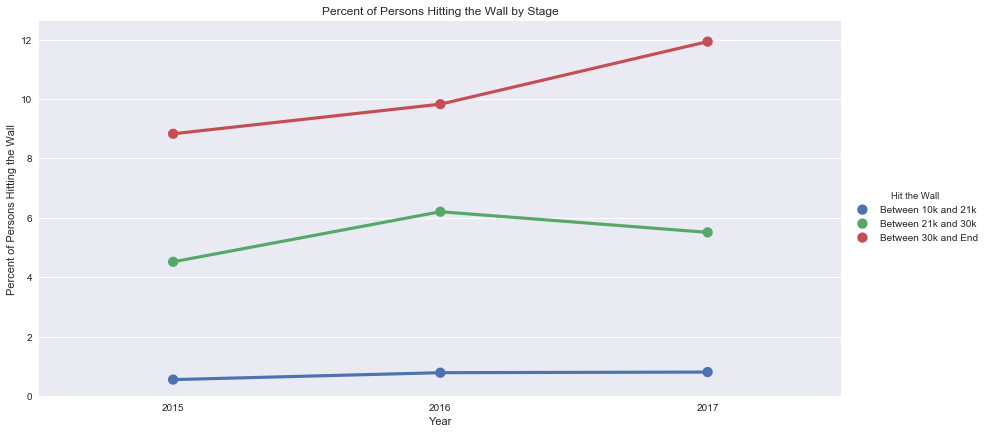

Note: Hitting the Wall defined as a slowdown of >20% compared to previous stage


In [96]:
#Hitting the Wall Breakdown
df_wall = (df.groupby(['Year', 'Hit the Wall'])['Total Time (mins)'].count())
wall_percent = (df_wall.groupby(level=[0]).apply(lambda x: (x / x.sum()*100)))
df_wall_percent = wall_percent.to_frame()
df_wall_percent = df_wall_percent.reset_index(level=['Year',"Hit the Wall"])
df_wall_percent = df_wall_percent.loc[df_wall_percent['Hit the Wall'] != 'Not Hit']
#print (df_wall_percent)
g = sns.factorplot(x="Year", y='Total Time (mins)', hue='Hit the Wall', data=df_wall_percent, size=6, aspect=2)
g = (g.set_axis_labels("Year", "Percent of Persons Hitting the Wall"))
plt.title('Percent of Persons Hitting the Wall by Stage')
plt.show()
print ("Note: Hitting the Wall defined as a slowdown of >20% compared to previous stage")

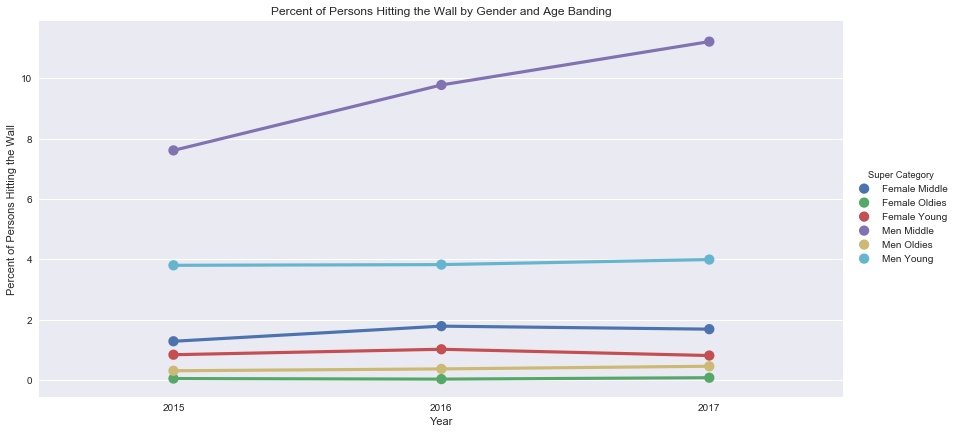

Note: Hitting the Wall defined as a slowdown of >20% in a stage compared to previous stage


In [97]:
#Hitting the Wall by Super Category (i.e. Gender and Age Banding)
df_wall_cat = (df.groupby(['Year', 'Hit the Wall Flag', 'Super Category'])['Total Time (mins)'].count())
wall_percent_cat = (df_wall_cat.groupby(level=[0]).apply(lambda x: (x / x.sum()*100)))
df_wall_percent_cat = wall_percent_cat.to_frame().reset_index()
df_wall_percent_cat = df_wall_percent_cat.loc[df_wall_percent_cat['Hit the Wall Flag'] != 'No']
#print (df_wall_percent_cat)
g = sns.factorplot(x="Year", y='Total Time (mins)', hue='Super Category', data=df_wall_percent_cat, size=6, aspect=2)
g = (g.set_axis_labels("Year", "Percent of Persons Hitting the Wall"))
plt.title('Percent of Persons Hitting the Wall by Gender and Age Banding')
plt.show()
print ("Note: Hitting the Wall defined as a slowdown of >20% in a stage compared to previous stage")